In [3]:
from typing import List, Dict, Tuple
Node = Tuple[int, int]
import numpy as np


In [4]:
def manhattan_distance(node1: Node, node2: Node) -> float:
    return abs(node1[0] - node2[0]) + abs(node1[1] - node2[1])


class LatticeDistance:

    def __init__(self, n: int) -> None:
        self.n = n

    def __call__(self, node1: Node, node2: Node) -> float:
        dx = abs(node1[0] - node2[0])
        dy = abs(node1[1] - node2[1])
        if dx > self.n / 2:
            dx = self.n - dx
        if dy > self.n / 2:
            dy = self.n - dy
        return dx + dy

def euclidean_distance(node1: Node, node2: Node) -> float:
    return ((node1[0] - node2[0])**2 + (node1[1] - node2[1])**2)**0.5

In [5]:
def num_of_distance(n,i):
    assert n % 2 == 1
    diameter = (n-1) // 2
    if i == 0:
        return 1
    if i <= diameter:
        return 4 * i
    z = 2*diameter - i+1
    return 4 * z

def generate_offset(n, i, o):
    assert n % 2 == 1
    assert i > 0

    diameter = (n-1) // 2
    num_possible = num_of_distance(n, i)
    assert 0 <= o < num_possible, f"o={o}, num_possible={num_possible}"

    start = max(0, i - diameter)
    end = min(diameter, i)

    is_cropped = i > diameter

    if is_cropped:
        y_sign = 1 if o % 2 == 0 else -1
        if o < num_possible // 2:
            x = -end + o // 2
            y = i - abs(x)
            return (x, y * y_sign)
        else:
            x = start + (o - num_possible // 2) // 2
            y = -i + abs(x)
            return (x, y * -y_sign)
    else:
        if o == 0:
            return -end, 0
        if o == num_possible - 1:
            return end, 0
        if o < num_possible // 2:
            o -= 1
            x = -end + 1 + o // 2
            y = i - abs(x)
            y_sign = 1 if o % 2 == 0 else -1
            return (x, y * y_sign)
        else:
            o -= num_possible // 2
            if o == 0:
                return start, -end
            o -= 1
            x = start + 1 + o // 2
            y = i - abs(x)
            y_sign = 1 if o % 2 == 0 else -1
            return (x, y * y_sign)
        

(100000,)


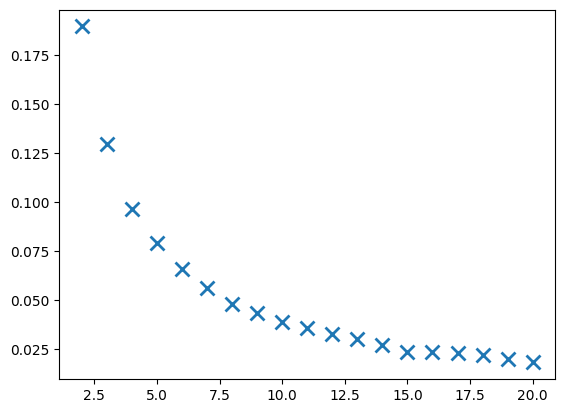

In [15]:
class MultinomialDistanceSampler:

    def __init__(self, n: int, alpha: float) -> None:
        assert n % 2 == 1
        self.n = n
        max_distance = n-1
        values = np.arange(2, max_distance+1)
        probas = values.astype(float)**(-alpha)
        for i, v in enumerate(values):
            probas[i] *= num_of_distance(n, v)
        probas /= probas.sum()
        self.values = values
        self.probas = probas

    def sample(self, n_samples: int) -> int:
        return np.random.choice(self.values, p=self.probas, size=n_samples)
    

class CachedMultinomialDistanceSampler(MultinomialDistanceSampler):

    def __init__(self, n: int, alpha: float, cache_size: int = 1_000_000) -> None:
        super().__init__(n, alpha)
        self.queue = None
        self.offset = 0
        self.cache_size = cache_size

    def sample(self, n_samples: int) -> List[int]:
        if self.queue is None or self.offset > self.cache_size - n_samples:
            self.queue = super().sample(self.cache_size)
        res = self.queue[self.offset:self.offset+n_samples]
        self.offset += n_samples
        return res
    

class ApproximateDistanceSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha

    def _inverse_cdf(self, u):
        r = self.alpha
        if r == 1:
            r = 1.0001
        return (self.n ** (1-r) - (self.n ** (1-r) - 2 ** (1-r)) * u) ** (1/(1-r))

    def sample(self, n_samples: int) -> List[int]:
        samples = np.random.uniform(0, 1, n_samples)
        return self._inverse_cdf(samples)
    


M, alpha = 21, 1.1
mds = ApproximateDistanceSampler(M, alpha)


samples = mds.sample(100000)
samples = np.floor(samples)
print(samples.shape)

from collections import Counter
import matplotlib.pyplot as plt

cnt = Counter(samples.tolist())

_mds = MultinomialDistanceSampler(M, alpha)
#plt.plot(_mds.values, _mds.probas, 'o')
plt.plot(list(cnt.keys()), np.array(list(cnt.values())) / 100000, 'x', markersize=10, markeredgewidth=2)

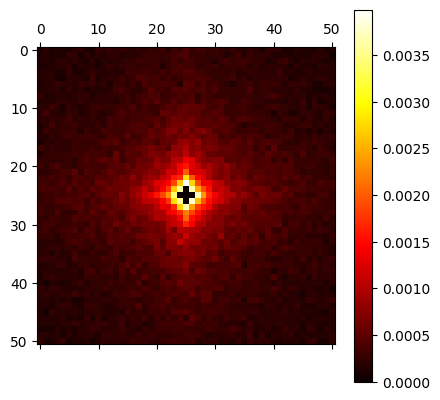

In [16]:
class OffsetSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.distance_sampler = MultinomialDistanceSampler(n, alpha)

    def sample(self) -> Node:
        distance = self.distance_sampler.sample(1)[0]
        index = np.random.randint(num_of_distance(self.n, distance))
        offset = generate_offset(self.n, distance, index)
        return offset
    

class NaiveOffsetSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.distance_sampler = MultinomialDistanceSampler(n, alpha)
        self.dmask = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                d = manhattan_distance((n//2, n//2), (i, j))
                self.dmask[i,j] = d
        
    def sample(self) -> Node:
        distance = self.distance_sampler.sample(1)[0]
        xs, ys = (self.dmask == distance).nonzero()
        offset = np.random.randint(len(xs))
        return xs[offset] - self.n // 2, ys[offset] - self.n // 2
        

                

M = 51
alpha = 1
os = NaiveOffsetSampler(M, alpha)

q = np.zeros((M, M))
for _ in range(100000):
    i,j = os.sample()
    i,j = i+M//2 % M, j+M//2 % M
    q[i,j] += 1
q /= q.sum()
plt.matshow(q, cmap='hot')
plt.colorbar()

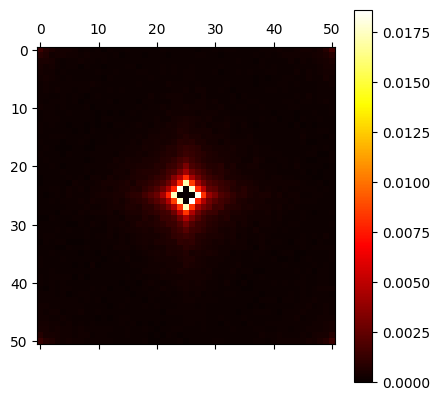

In [664]:
M = 51
alpha = 1
os = NaiveOffsetSampler(M, alpha)

q2 = np.zeros((M, M))
for _ in range(100000):
    i,j = os.sample()
    i,j = i+M//2 % M, j+M//2 % M
    q2[i,j] += 1
q2 /= q2.sum()
plt.matshow(q2, cmap='hot')
plt.colorbar()

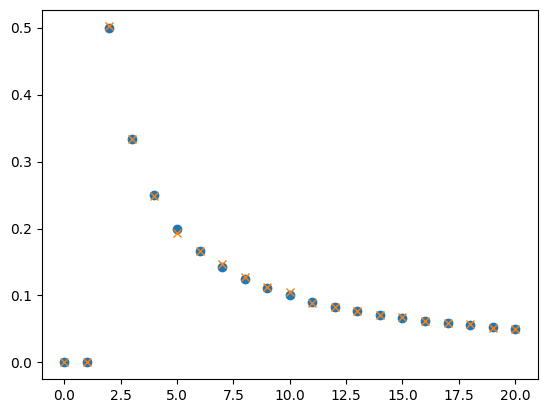

In [627]:
distances = []
probas = []
empirical = []
for d in range(0, M):
    xs, ys = (y.dmask == d).nonzero()
    distances.append(d)
    probas.append(0 if d < 2 else d**-alpha)
    empirical.append(sum(q[xs, ys])*2.6)

plt.plot(distances, probas, 'o')
plt.plot(distances, empirical, 'x')


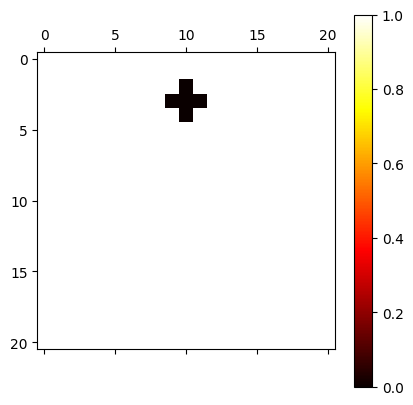

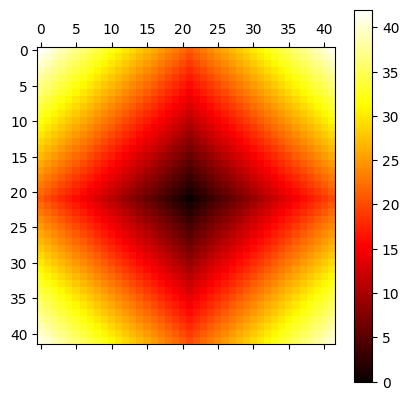

In [17]:
class NaiveLongRangeSampler:

    def __init__(self, n: int, alpha: float) -> None:
        self.n = n
        self.alpha = alpha
        self.distance_sampler = MultinomialDistanceSampler(n*2+1, alpha)
        self.dmask = np.zeros((n*2, n*2))
        for i in range(n*2):
            for j in range(n*2):
                d = manhattan_distance((n, n), (i, j))
                self.dmask[i,j] = d
        

    def sample_lr(self, current: Node) -> Node:
        max_dx = max(current[0], self.n - current[0])
        max_dy = max(current[1], self.n - current[1])
        max_distance = max_dx + max_dy
        distance = max_distance + 1
        while distance >= max_distance-1:
            distance = self.distance_sampler.sample(1)[0]
        xs, ys = (self.dmask == distance).nonzero()
        xs = xs - self.n + current[0]
        ys = ys - self.n + current[1]
        keep_mask = []
        for i, (x, y) in enumerate(zip(xs, ys)):
            keep = 0 <= x < self.n and 0 <= y < self.n
            keep_mask.append(keep)
        keep_mask = np.array(keep_mask, dtype=bool)
        xs = xs[keep_mask]
        ys = ys[keep_mask]
        offset = np.random.randint(len(xs))
        return xs[offset], ys[offset]

    
lrs = NaiveLongRangeSampler(21, 1)

q = np.zeros((21, 21))
for _ in range(10000):
    i,j = lrs.sample_lr((3, 10))
    q[i,j] += 1

q /= q.sum()
plt.matshow(q > 0, cmap='hot')
plt.colorbar()
plt.show()

plt.matshow(lrs.dmask, cmap='hot')
plt.colorbar()


In [19]:
class NaiveSimulator:

    def __init__(self, n: int, offset_sampler: OffsetSampler) -> None:
        self.n = n
        self.offset_sampler = offset_sampler

    def simulate(self, target: Node) -> int:
        n_rounds = 0
        current = (np.random.randint(self.n), np.random.randint(self.n))
        while current != target:
            n_rounds += 1
            long_range = self.offset_sampler.sample()
            
            current_distance = manhattan_distance(current, target) - 1
            long_range_distance = manhattan_distance(long_range, target)
            if long_range_distance < current_distance:
                current = long_range
            else:
                if current[0] < target[0]:
                    current = (current[0] + 1, current[1])
                elif current[0] > target[0]:
                    current = (current[0] - 1, current[1])
                else: 
                    if current[1] < target[1]:
                        current = (current[0], current[1] + 1)
                    else:
                        current = (current[0], current[1] - 1)
        return n_rounds
        
    

class PeriodicalLatticeSimulator:

    def __init__(self, n: int, offset_sampler: OffsetSampler) -> None:
        assert n % 2 == 1, "Works for odd n only."
        self.n = n
        #self.lattice_distance = lattice_distance
        self.diameter = (n-1)//2
        self.offset_sampler = offset_sampler


    def simulate(self, target: Node) -> int:
        assert target[0] <= self.diameter and target[1] <= self.diameter, "Target is out of bounds."
        n_rounds = 0
        while target != (0, 0):
            n_rounds += 1
            #
            #long_range = self.offset_sampler.sample()
            long_range = list(map(abs, self.offset_sampler.sample()))
            long_range_distance = manhattan_distance(target, long_range)
            current_distance = manhattan_distance((0, 0), target)
            
            if long_range_distance < current_distance:
                target = (target[0] - long_range[0], target[1] - long_range[1])
            else:
                if target[0] > 0:
                    target = (target[0] - 1, target[1])
                else:
                    target = (target[0], target[1] - 1)
            # corrigate flips
            target = (abs(target[0]), abs(target[1]))
        return n_rounds
        

sim = NaiveSimulator(21, NaiveLongRangeSampler(21, 1))
sim.simulate((10, 10))

AttributeError: 'NaiveLongRangeSampler' object has no attribute 'sample'

In [22]:
from tqdm import tqdm

NSIM = 50
N = 201

result = []
alphas = []
for alpha in tqdm(np.linspace(0, 2.5, 26), total=26):
    curr_result = []
    offset_sampler = OffsetSampler(N, alpha)
    #lattice_distance = LatticeDistance(N)
    for _ in range(NSIM):
        simulator = NaiveSimulator(N, offset_sampler) #AperiodicLatticeSimulator(N, offset_sampler)
        target = (np.random.randint(N), np.random.randint(N))
        #start = (np.random.randint(N), np.random.randint(N))
        #target = (target[0] - start[0], target[1] - start[1])
        #target = list(map(abs, target))
        #target = (target[0] % (N//2), target[1] % (N//2))
        steps = simulator.simulate(target)
        curr_result.append(steps)
    alphas.append(alpha)
    result.append((np.mean(curr_result), np.std(curr_result)))


100%|██████████| 26/26 [00:02<00:00, 10.44it/s]


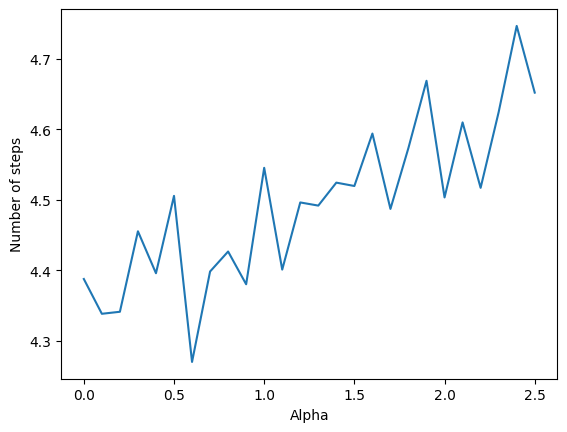

In [23]:
import matplotlib.pyplot as plt

result = np.array(result)
#plt.errorbar(np.linspace(0, 2.5, 26), np.log(result[:, 0]))
#plt.plot(np.linspace(0, 2.5, 26), result[:, 0])
plt.plot(alphas, np.log(result[:, 0]))
plt.xlabel("Alpha")
plt.ylabel("Number of steps")
#plt.yscale("log")
plt.show()

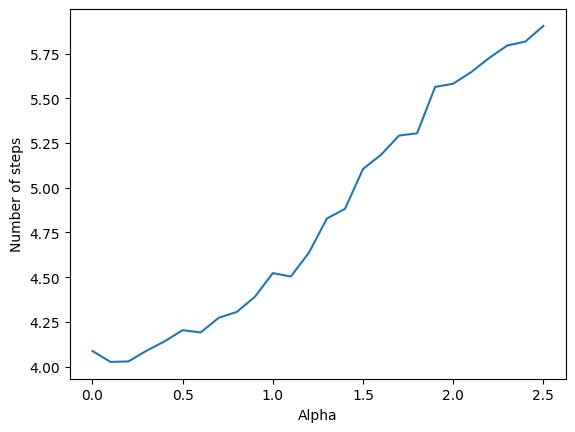

In [744]:
import matplotlib.pyplot as plt

result = np.array(result)
#plt.errorbar(np.linspace(0, 2.5, 26), np.log(result[:, 0]))
#plt.plot(np.linspace(0, 2.5, 26), result[:, 0])
plt.plot(alphas, np.log(result[:, 0]))
plt.xlabel("Alpha")
plt.ylabel("Number of steps")
#plt.yscale("log")
plt.show()

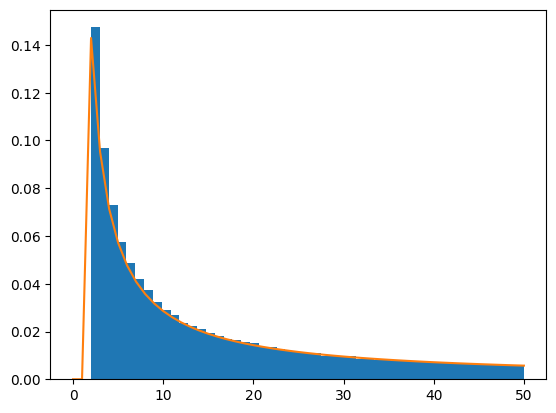

In [146]:
import matplotlib.pyplot as plt
Z = 100000
N = 51
nbins = 49
mds = MultinomialDistanceSampler(N, 1)
plt.hist(mds.sample(Z), bins=nbins, density=True)
plt.plot(mds.values, mds.probas)